# Import required modules

In [1]:
import anndata
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scanpy as sc
from scnym.api import scnym_api

import sys, os, joblib
import numpy_groupies as npg
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression

In [2]:
import session_info
session_info.show()

## Read in anndata

In [3]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/CM_LVs_raw.h5ad')
adata

AnnData object with n_obs × n_vars = 492943 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'

In [4]:
# summarise cell type annotation
## barcodes from Chaffin
chaffin_obsnames = adata.obs_names[adata.obs['dataset']=='Chaffin_Nature_2022']

adata.obs['cell_state']=adata.obs['cell_state'].astype('str')
adata.obs.loc[chaffin_obsnames,'cell_state']=adata.obs.loc[chaffin_obsnames,'cell_type_leiden0.6'].copy()
adata.obs['cell_state']=adata.obs['cell_state'].astype('category')

pd.crosstab(adata.obs['cell_state'],adata.obs['dataset'])

dataset,Chaffin_Nature_2022,HCAv2,Reichart_Science_2022
cell_state,,,
Cardiomyocyte_I,149565,0,0
Cardiomyocyte_II,5447,0,0
Cardiomyocyte_III,3457,0,0
vCM1,0,78810,0
vCM1.0,0,0,85041
vCM1.1,0,0,17518
vCM1.2,0,0,16234
vCM1.3,0,0,16997
vCM2,0,19886,27955


In [5]:
print(adata.X.data[:10])
adata.obs['cell_state'].cat.categories

[1. 1. 3. 4. 1. 1. 3. 1. 1. 2.]


Index(['Cardiomyocyte_I', 'Cardiomyocyte_II', 'Cardiomyocyte_III', 'vCM1',
       'vCM1.0', 'vCM1.1', 'vCM1.2', 'vCM1.3', 'vCM2', 'vCM3', 'vCM3.0',
       'vCM3.1', 'vCM4', 'vCM5'],
      dtype='object')

In [6]:
adata.obs['dataset'].value_counts()

Reichart_Science_2022    201974
Chaffin_Nature_2022      158469
HCAv2                    132500
Name: dataset, dtype: int64

## HCAv2 model

In [9]:
ref = adata[adata.obs['dataset']=='HCAv2']
ref

View of AnnData object with n_obs × n_vars = 132500 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total

In [10]:
ref.obs['cell_state'].value_counts()

vCM1    78810
vCM2    19886
vCM4    17579
vCM3    16064
vCM5      161
Name: cell_state, dtype: int64

In [ ]:
# downsize
# HCA_vCM_d = msc.downsize_cell(HCA_vCM, groupby='cell_states', n_down=2000, seed=1)
# HCA_vCM_d.obs['cell_states'].value_counts()

In [11]:
# filter genes
sc.pp.filter_genes(ref, min_cells=3)

# normalize
sc.pp.normalize_total(ref, target_sum=1e4)
sc.pp.log1p(ref)

Trying to set attribute `.var` of view, copying.


In [12]:
ref.X.data[:10]

array([0.42356586, 0.42356586, 0.94863987, 1.1344919 , 0.42356586,
       0.42356586, 0.94863987, 0.42356586, 0.42356586, 0.72017694],
      dtype=float32)

In [13]:
# train scNym model
scnym_api(
    adata=ref,
    task='train',
    groupby='cell_state',
    out_path='/nfs/team205/heart/scnym/model_HCAv2_CMs',
    config='new_identity_discovery',
)

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

No unlabeled data was found.
Did you forget to set some examples as `"Unlabeled"`?
Proceeding with purely supervised training.

X:  (132500, 28947)
y:  (132500,)
Not weighting classes and not balancing classes.
Found 2 unique domains.
Training...
Saving best model weights..._____________|
Saved best weights.
>>>>> 46/99|-------------_________________|
Early stopping at epoch 46
>>>>>
Training complete.

Evaluating model.
EVAL LOSS:  0.64849137285581
EVAL ACC :  0.8142641509433962
Predictions | Labels
[[0 0]
 [2 2]
 [0 0]
 [0 0]
 [1 1]
 [2 2]
 [0 0]
 [1 3]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 1]
 [0 3]
 [0 3]]


## Query: Chaffin

In [28]:
que_cf = adata[adata.obs['dataset']=='Chaffin_Nature_2022']
que_cf

View of AnnData object with n_obs × n_vars = 158469 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total

In [29]:
# filter genes and cells
sc.pp.filter_genes(que_cf, min_cells=3)

# normalize
sc.pp.normalize_total(que_cf, target_sum=1e4)
sc.pp.log1p(que_cf)

que_cf.X.data[:10]

Trying to set attribute `.var` of view, copying.


array([0.5001006 , 0.83194095, 0.83194095, 0.5001006 , 0.5001006 ,
       0.5001006 , 0.5001006 , 1.2796966 , 0.5001006 , 0.5001006 ],
      dtype=float32)

In [30]:
# predict
scnym_api(
    adata=que_cf,
    task='predict',
    key_added='scNym',
    config='new_identity_discovery',
    trained_model='/nfs/team205/heart/scnym/model_HCAv2_CMs',
)

que_cf.obs['scNym']=que_cf.obs['scNym'].astype('category')

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

Loaded model predicting 5 classes from 28947 features
['vCM1' 'vCM2' 'vCM3' 'vCM4' 'vCM5']
Building a classification matrix...


mapping genes: 28994it [00:31, 917.71it/s]
Finding cell types:   0%|          | 0/155 [00:00<?, ?it/s]

Found 28044 common genes.
Predicting cell types...


Finding cell types: 100%|██████████| 155/155 [01:06<00:00,  2.34it/s]


Extracting model embeddings...


In [31]:
que_cf.obs['disease_donor']=que_cf.obs['disease'].astype('str')+'_'+que_cf.obs['donor'].astype('str')

[]

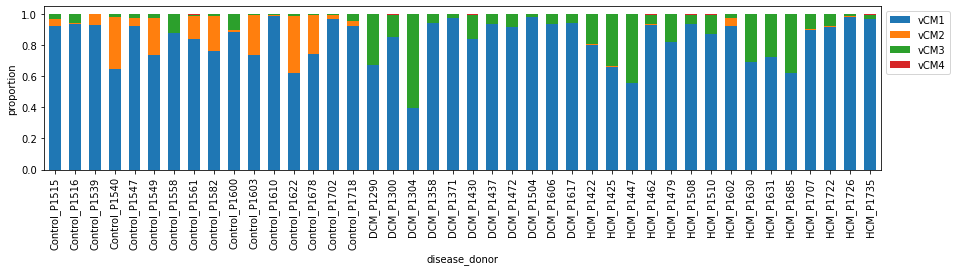

In [32]:
tmp = pd.crosstab(que_cf.obs['disease_donor'], que_cf.obs['scNym'], normalize='index')

plt.rcParams['figure.figsize'] = 15,3

# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.6)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [33]:
que_cf.write('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/CM_LVs_Chaffin_scnym.h5ad')

... storing 'disease_donor' as categorical


## Query: Reichart

In [34]:
que_rc = adata[adata.obs['dataset']=='Reichart_Science_2022']
que_rc

View of AnnData object with n_obs × n_vars = 201974 × 32732
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total

In [35]:
# filter genes and cells
sc.pp.filter_genes(que_rc, min_cells=3)

# normalize
sc.pp.normalize_total(que_rc, target_sum=1e4)
sc.pp.log1p(que_rc)

que_rc.X.data[:10]

Trying to set attribute `.var` of view, copying.


array([1.5636945, 1.5636945, 1.5636945, 1.5636945, 1.5636945, 1.5636945,
       1.5636945, 1.5636945, 1.5636945, 1.5636945], dtype=float32)

In [36]:
# predict
scnym_api(
    adata=que_rc,
    task='predict',
    key_added='scNym',
    config='new_identity_discovery',
    trained_model='/nfs/team205/heart/scnym/model_HCAv2_CMs',
)

que_rc.obs['scNym']=que_rc.obs['scNym'].astype('category')

No CUDA device found.
Computations will be performed on the CPU.
Add a CUDA compute device to improve speed dramatically.

Loaded model predicting 5 classes from 28947 features
['vCM1' 'vCM2' 'vCM3' 'vCM4' 'vCM5']
Building a classification matrix...


mapping genes: 28369it [00:32, 882.40it/s]
Finding cell types:   0%|          | 0/198 [00:00<?, ?it/s]

Found 27782 common genes.
Predicting cell types...


Finding cell types: 100%|██████████| 198/198 [01:24<00:00,  2.34it/s]


Extracting model embeddings...


In [37]:
que_rc.obs['disease_donor']=que_rc.obs['disease'].astype('str')+'_'+que_rc.obs['donor'].astype('str')

[]

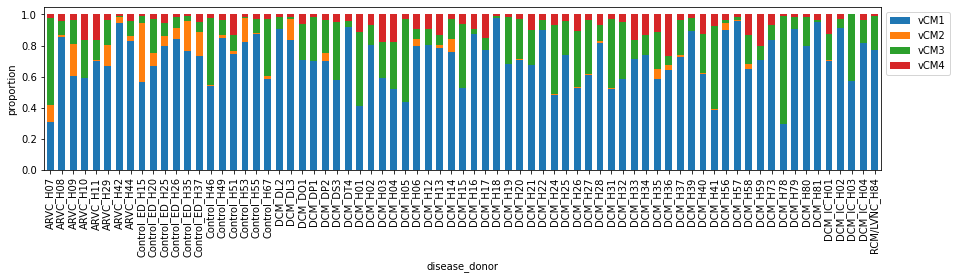

In [38]:
tmp = pd.crosstab(que_rc.obs['disease_donor'], que_rc.obs['scNym'], normalize='index')

plt.rcParams['figure.figsize'] = 15,3

# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.6)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [39]:
que_rc.write('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/CM_LVs_Reichart_scnym.h5ad')

... storing 'disease_donor' as categorical


## Statistical analysis

In [26]:
import scipy
from statsmodels.stats.multitest import multipletests

In [9]:
# read in
que_cf = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/CM_LVs_Chaffin_scnym.h5ad',
                     backed='r')
que_cf

AnnData object with n_obs × n_vars = 158469 × 28994 backed at '/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/CM_LVs_Chaffin_scnym.h5ad'
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellrang

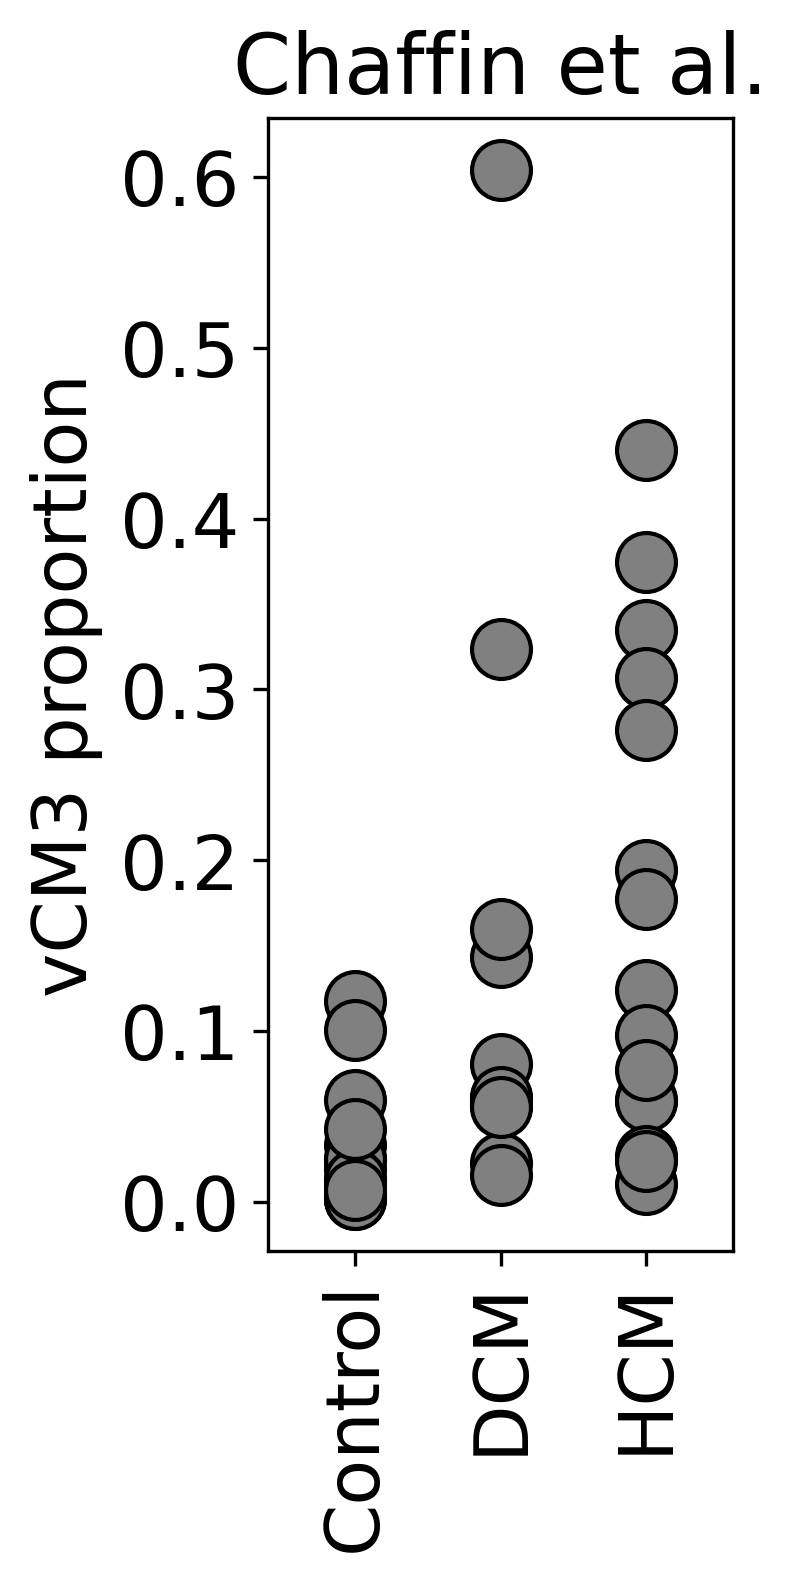

Result of stats
{'conrtol_vs_DCM': RanksumsResult(statistic=-3.010129004440943, pvalue=0.002611367506413849), 'conrtol_vs_HCM': RanksumsResult(statistic=-3.4389769554331124, pvalue=0.0005839169374088534)}

Adjusted p-values for multiple comparisons


{'conrtol_vs_DCM': 0.005222735012827698,
 'conrtol_vs_HCM': 0.0011678338748177068}

In [37]:
# Chaffin
df = que_cf.obs[['disease_donor','scNym']].copy()
df['vCM3']=df['scNym']=='vCM3'
df.drop(['scNym'],axis=1,inplace=True)

df=df.groupby('disease_donor').apply(lambda x:np.sum(x)/len(x))
df['disease']=[x.split('_')[0] for x in df.index]

plt.rcParams['figure.figsize'] = 2,5
plt.rcParams["figure.dpi"] = 300
plt.scatter(x='disease',y='vCM3',data=df,c='grey',edgecolors='black',s=200)
plt.margins(x=0.3)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.ylabel('vCM3 proportion',fontsize=18)
plt.title('Chaffin et al.', fontsize=20)
plt.savefig('/home/jovyan/projects/P56_pre-clinical-fibrosis/notebooks/figures/vCM3_chaffin.pdf',
           bbox_inches='tight')
plt.show()

# p values
stats_res = {}
stats_res['conrtol_vs_DCM'] = scipy.stats.ranksums(df[df['disease']=='Control']['vCM3'],
                                                    df[df['disease']=='DCM']['vCM3'])
stats_res['conrtol_vs_HCM'] = scipy.stats.ranksums(df[df['disease']=='Control']['vCM3'],
                                                    df[df['disease']=='HCM']['vCM3'])
print('Result of stats')
print(stats_res)

# pvalue collection
pval_adjusted = {}
res = multipletests([x[1] for x in stats_res.values()], method='bonferroni')
for i,k in enumerate(stats_res.keys()):
    pval_adjusted[k] = res[1][i]

print('')
print('Adjusted p-values for multiple comparisons')
pval_adjusted

In [4]:
# read in
que_rc = sc.read_h5ad('/nfs/team205/heart/anndata_objects/8regions/8reg_reichart_chaffin/CM_LVs_Reichart_scnym.h5ad')
que_rc

AnnData object with n_obs × n_vars = 201974 × 28369
    obs: 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'batch_key', 'leiden_scVI', 'cell_type', 'cell_state_HCAv1', 'cell_state_scNym', 'cell_state_scNym_confidence', 'cell_state', 'dataset', 'disease', 'Gene', 'Clinical.dominant.mutation', 'Mutation.Type', 'Origin', 'percent_mito', 'percent_ribo', 'n_counts', 'solo_score', 'predicted_doublets_solo', 'scrublet_score_log', 'predicted_doublets_log', 'Replicate', 'cell_states_long', 'validated', 'cell_type_validated', 'sex', 'lvef', 'cell_type_leiden0.6', 'SubCluster', 'cellbender_ncount', 'cellbender_ngenes', 'cellranger_percent_mito', 'exon_prop', 'cellbender_entropy', 'cellranger_doublet_scores', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts'

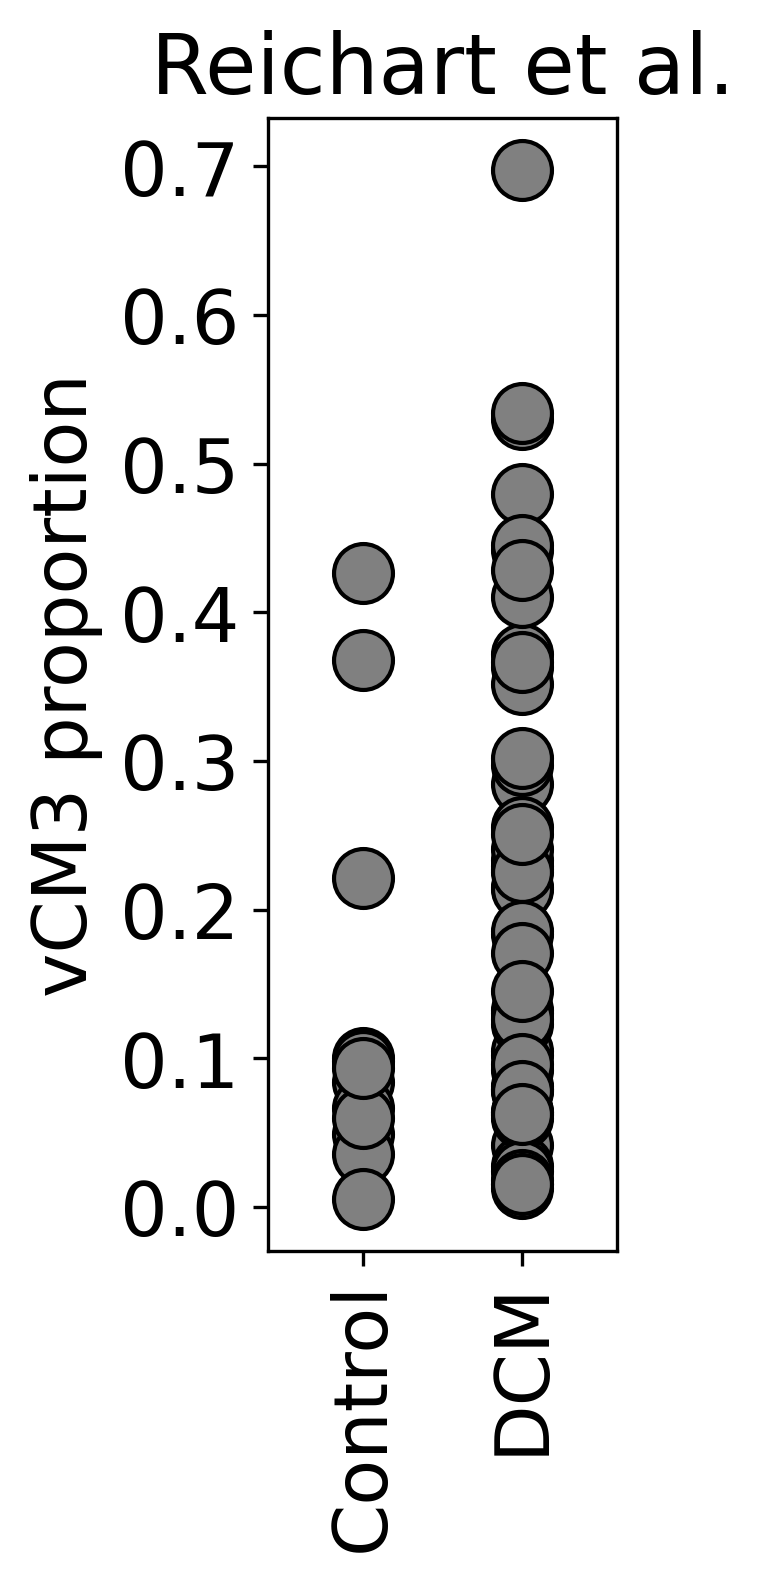

RanksumsResult(statistic=-1.5824481071536973, pvalue=0.11354730987639441)

In [32]:
# Reichart
df = que_rc.obs[['disease_donor','scNym']].copy()
df['vCM3']=df['scNym']=='vCM3'
df.drop(['scNym'],axis=1,inplace=True)

df=df.groupby('disease_donor').apply(lambda x:np.sum(x)/len(x))
df['disease']=[x.split('_')[0] for x in df.index]
df=df[df['disease'].isin(['Control','DCM'])]

plt.rcParams['figure.figsize'] = 1.5,5
plt.rcParams["figure.dpi"] = 300
plt.scatter(x='disease',y='vCM3',data=df,c='grey',edgecolors='black',s=200)
plt.margins(x=0.6)
plt.xticks(fontsize=18,rotation=90)
plt.yticks(fontsize=18)
plt.ylabel('vCM3 proportion',fontsize=18)
plt.title('Reichart et al.', fontsize=20)
plt.savefig('/home/jovyan/projects/P56_pre-clinical-fibrosis/notebooks/figures/vCM3_reichart.pdf',
           bbox_inches='tight')
plt.show()

scipy.stats.ranksums(df[df['disease']=='Control']['vCM3'],
                     df[df['disease']=='DCM']['vCM3']
                    )